##### A derivative work based on an original notebook with copyright 2020 by "The TensorFlow Hub Authors."

Important: You must set up the runtime to use GPU or the fine-tuning training of the BERT model will take a very long time.

This tutorial demonstrates fine-tuning a BERT model to perform sentiment analysis on a dataset of plain-text IMDB movie reviews. In addition to training a model, we will preprocess text into an appropriate format.

Here's an overview of the steps:

1. Load the IMDB dataset
2. Load a BERT model from TensorFlow Hub
3. Build a model by combining BERT with a classifier
4. Train the model, fine-tuning BERT as part of that
5. Save the model and use it to classify sentences

Note: This is a derivative work licensed under the Apache License, Version 2.0.



## Setup

The "TensorFlow Model Garden" is a repository of models made available to the public by the Tensorflow authors. The "official" area contains a set of models that are well-vetted and maintained. As these are not part of the Colab image, we must use pip install to load them into the VM. 

We will use a relatively new suite of text preprocessing tools from tensorflow-text that move many of the routine tasks from regular python code into the tensorflow ecosystem.

We will also use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models). AdamW implements a form of normalization on the computation of gradients that improves generalizabaility of resulting models. Using AdamW to train has shown superior results in a variety of classification tasks.

In [1]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 71.7 MB/s eta 0:00:00


In [2]:
!pip install -q tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.6/240.6 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 630.1/630.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 39.2 MB/s eta 0:00:00


In [3]:
import os # Operating system utilities
import shutil # Shell utilities for high level file operations

import tensorflow as tf # Basic tensorflow setup
import tensorflow_hub as hub # Here's how we get access to several newer features
import tensorflow_text as text # Nice new text preprocessing
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

# This sets the logger to a different level than the default, which is WARNING
tf.get_logger().setLevel('ERROR')

save_model = True # Flag to control saving to disk

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

We use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) containing 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [4]:
# This take about half a minute

# Here's an online repository that contains the data we need
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
basefile = 'aclImdb_v1.tar.gz'

# This utility will also untar/unzip the file for us
dataset = tf.keras.utils.get_file(basefile, url, untar=True, cache_dir='.',
                                  cache_subdir='')

# Concatenate the path name
dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

# Concatenate the path name
train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir) # Shell utilities / high level file ops

84125825/84125825 [==============================] - 9s 0us/step


In [ ]:
#
# Exercise 12.1: Examine the aclImdb folder structure in the Files viewer.
# Write a comment describing what you see.
#
#The folder contains a vocab file of imdb.vocab
#Test and train folders are separate
#Each test and train file has separate negative and positive reviews

Next, use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. While the test set helps govern the training process and prevent overfitting, the validation set stands apart and is not used until the model is fully trained. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [5]:
# Prefetch elements from the input dataset ahead of the time they are requested
AUTOTUNE = tf.data.AUTOTUNE

batch_size = 32 # Number of instances in a batch
seed = 42 # Control randomization. Why 42?

print("Processing training data. . .")
# This utility eats up the data in the aclImdb/train folder
raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Processing training data for validation. . .")
# A complete directory of data ingested and organized in one function call
val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

# Caching and pre-fetch will speed up the preprocessing of training data
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

print("Processing test data. . .")
test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

# Caching and pre-fetch will also speed up the preprocessing of test data
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Processing training data. . .
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Processing training data for validation. . .
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Processing test data. . .
Found 25000 files belonging to 2 classes.


In [ ]:
#
# Exercise 12.2: Look up what tf.data.AUTOTUNE does and write a comment here.
# Hint: Look at the buffer_size argument in the call to prefetch()
#
#tf.data.AUTOTUNE buffer_size=AUTOTUNE in prefetch:
#tf.data.AUTOTUNE can be passed to prefecth or cache methods.
#t allows TensorFlow to automatically tune the prefetching buffer size for optimal performance
#according to hardware configurations.
#It helps improving performance of the tensorflow pipelines

Let's take a look at a few reviews.

In [6]:
# The take() method let's us peel off one set from a batch 
for text_batch, label_batch in train_ds.take(1):
  for i in range(5): # Then we can look at some of the instances
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

In [12]:
#
# Exercise 12.3 - Use the skip() method together with the take() method
# to examine batch of reviews in the range of 6 to 10.
#
for text_batch, label_batch in train_ds.skip(5).take(1):
  for i in range(5): # Then we can look at some of the instances
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'There\'s no denying the first Azumi film was a commercial product; it was an adaptation of a popular manga and had cast of young, attractive actors and certainly wasn\'t lacking in the budget department. Yet it more than entertained for what it was, and I can\'t deny I enjoyed it immensely.<br /><br />"Azumi 2" lacks just about everything that made the original so wonderful. The first thing that should set alarm bells ringing is the absence of the superb Ryuhei Kitamura at the helm. With him, he seemed to take not only his own visual flair and kinetics, but the originals style, beauty and most importantly, its heart. While the first had a simple "hitlist" plot, this one has a corkscrew mess of a story, with too many dull characters stabbing each other in the back so many times the potential for any sympathy or pathos is obliterated. Gone is the effective interplay between the lead characters; Azumi and her cohorts are often reduced to a bunch of stroppy teenagers arguing in a

## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) because this will be faster to fine-tune. A small model  with higher accuracy would be ALBERT. If you want even better accuracy, choose one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned in a Colab VM. 

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

You can read the original BERT model hyperparameters from the filenames below. For example, L=4 hidden layers, a hidden vector size of H=512, and A=8 attention heads for a dictionary of lowercased English words would be bert_en_uncased_L-4_H-512_A-8. Roughly speaking, models with larger internal components will take much longer to fine-tune but will also exhibit much greater context sensitivity.

Note the use of Jupyter forms in this code box - some of these features are unique to Colab. You can use the dropdown arrow at the far right to select among the options. These are controlled by @param.

In [52]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-6_H-768_A-12'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [53]:
#
# Exercise 12.4 - Create a small Jupyter form here that controls batch size.
# Have the batch_size default to 32 as it was set in an earlier code block.
# Hint: This notebook provides an easy overview and tutorial of forms in
# Colab notebooks: https://colab.research.google.com/notebooks/forms.ipynb
#
number_slider = 32 #@param {type:"slider", min:10, max:128, step:1}
print(number_slider)

32


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. Having tensorflow manage these processes without regular Python code can enable great speed improvements in preprocessing large datasets.

The preprocessing model MUST be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [54]:
# Wraps a SavedModel (or a legacy TF1 Hub format) as a Keras Layer
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

type(bert_preprocess_model)

tensorflow_hub.keras_layer.KerasLayer

Let's try the preprocessing model on a piece of text and see the output:

In [55]:
text_test = ['This is a truly awful, terrible, stinky movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}') # Just show the first 12 IDs; we don't need to review all 128 of them
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}') # Just show the first 12 masks; note that once we get into the pads, they are all masked off
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}') # See below about multi-element input

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  1037  5621  9643  1010  6659  1010 27136  2100  3185]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Note how the word ID output shows a start token (101) and an end token (102), as well as pad tokens on the end. All BERT models use these markers to set the context for the words in a sentence. Note that BERT also uses a SEP character for multi-element input (as in more than one sentence in a single input sequence). One of the innovations of BERT is that it generates  embeddings that are context-sensitive through self-attention. To accomplish that trick we need the start and end markers to help establish the context for each word in the sequence.

In [56]:
#
# Exercise 12.5 - Make a change to one word in text_test and rerun the code
# in the block just above. Copy the code to this block so you can compare 
# the outputs. Make sure to save the output of bert_preprocess_model(text_test)
# to a different variable, so you have two preprocessor outputs for later.
#
text_test2 = ['This is a truly beautiful, terrible, stinky movie!']
text_preprocessed2 = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed2.keys())}')
print(f'Shape      : {text_preprocessed2["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed2["input_word_ids"][0, :12]}') # Just show the first 12 IDs; we don't need to review all 128 of them
print(f'Input Mask : {text_preprocessed2["input_mask"][0, :12]}') # Just show the first 12 masks; note that once we get into the pads, they are all masked off
print(f'Type Ids   : {text_preprocessed2["input_type_ids"][0, :12]}') # See below about multi-element input

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2023  2003  1037  5621  9643  1010  6659  1010 27136  2100  3185]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [57]:
# Again with the wrapper: Wraps a SavedModel (or a legacy TF1 Hub format) as a Keras Layer
bert_model = hub.KerasLayer(tfhub_handle_encoder)

type(bert_model)

tensorflow_hub.keras_layer.KerasLayer

In [58]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.16053838 -0.27219185  0.438637    0.3036405  -0.09600565 -0.34465447
  0.50792944 -0.58160806  0.07469921  0.3828426  -0.9632549  -0.8083539 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.07618193 -0.31737947 -0.4014785  ... -0.4593331   0.07710469
   0.82023823]
 [ 0.327652    0.13737716 -0.5779009  ... -0.41215688  0.15135515
   0.31142122]
 [-0.43388352 -0.25980157 -0.49037224 ...  0.40389237 -0.5288578
   0.6716922 ]
 ...
 [ 0.38968724 -0.16754736 -0.65737295 ... -0.2817206   0.20104298
   0.5089858 ]
 [ 0.34887335 -0.36809838 -0.6959432  ...  0.12742592 -0.03341261
   0.42347735]
 [ 0.08028224  0.3274457  -0.40305227 ... -0.26666847  0.2974277
   0.46419546]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. In this case H is the vector dimensionality of the hidden vectors. You can think of each one of these vectors as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as an embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning we will be using the `pooled_output` array.

In [59]:
#
# Exercise 12.6 - Run your second preprocessed sentence through the bert_model
# as shown above. 
#
bert_results2 = bert_model(text_preprocessed2)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results2["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results2["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results2["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results2["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[ 0.16053838 -0.27219185  0.438637    0.3036405  -0.09600565 -0.34465447
  0.50792944 -0.58160806  0.07469921  0.3828426  -0.9632549  -0.8083539 ]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.07618193 -0.31737947 -0.4014785  ... -0.4593331   0.07710469
   0.82023823]
 [ 0.327652    0.13737716 -0.5779009  ... -0.41215688  0.15135515
   0.31142122]
 [-0.43388352 -0.25980157 -0.49037224 ...  0.40389237 -0.5288578
   0.6716922 ]
 ...
 [ 0.38968724 -0.16754736 -0.65737295 ... -0.2817206   0.20104298
   0.5089858 ]
 [ 0.34887335 -0.36809838 -0.6959432  ...  0.12742592 -0.03341261
   0.42347735]
 [ 0.08028224  0.3274457  -0.40305227 ... -0.26666847  0.2974277
   0.46419546]]


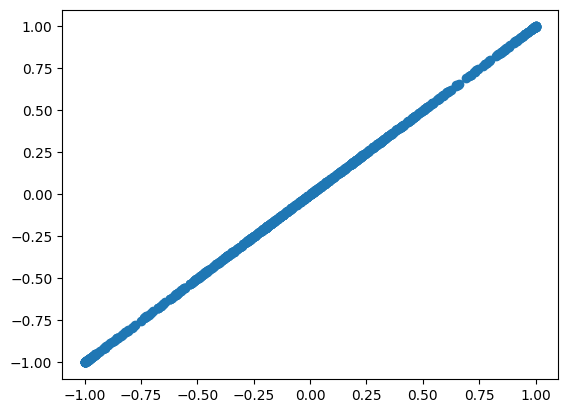

In [60]:
#
# Advanced/Optional Exercise 12.7 - Use a graphic (such as a scatterplot) or 
# statistic (such as a correlation) to compare the
# the pooled outputs from the two similar test sentences.
#
import matplotlib.pyplot as plt
plt.scatter(bert_results["pooled_output"], bert_results2["pooled_output"])

## Define your model

You will create an extremely simple model to fine-tune, with the preprocessing model, the selected BERT model, and one Dense node preceded by a Dropout layer. The Dropout layer is to control overfitting. The single Dense node is what will predict our two-class output.

Note: for more information about the base model's input and output, follow the model's URL to review documentation. Because we used the preprocessing model that was paired with our BERT model, we don't need to mess with the preprocessing details.


In [61]:
# Model building call: We are using the functional interface here.
def build_classifier_model(dropout_ratio):
  #Take input ans store as a tensor layer of input
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  #Create preprocessing layer 
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  #Create encoder inputs from preprocessing layer
  encoder_inputs = preprocessing_layer(text_input)
  #Define the coder with trainable parameters = True to fine tune the model
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder') # Here's the BERT model, with trainable=True so that we can fine tune
  #Create output from encoder using encoder inputs
  outputs = encoder(encoder_inputs)
  #Create output of the pooled out
  net = outputs['pooled_output']
  #Add a dropout layer to prevent overfitting
  net = tf.keras.layers.Dropout(dropout_ratio)(net) # Help to prevent overfitting
  
  # End with the ability to do binary classification: But why is activation=None?
  #The final classification model in BERT is a dense layer, with no activation function
  #Because this output of unnormalised logits is then passed to the softmax function 
  #to obtain class probabilities
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net) 
  return tf.keras.Model(text_input, net)

In [62]:
#building a classification model using BERT attention weights
classifier_model = build_classifier_model(dropout_ratio=0.1)
#We see the type of classifier model as keras engine functional type
type(classifier_model)

keras.engine.functional.Functional

In [63]:
#
# Exercise 12.8 - Add comments to the build_classifier_model(), documenting 
# each layer of the model. Then run a model.summary() to look at the model
# configuration.
#
classifier_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                    

Let's check that the model runs with the output of the preprocessing model.

In [64]:
# Process one instance into the not-yet-fine-tuned model
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.86313164]], shape=(1, 1), dtype=float32)


#Checkpoint! Report the Sigmoid Results of Processing Test Text

The code block just above produced a tensor containing just one value which was the result of using a sigmoid transformation on the output of the "not yet fine tuned" model. Write your name on the white board with the value next to it. You can round to three digits of precision.



#Discuss: Discuss the fine tuning process with your partner

Make sure you understand what has happened so far. We have initialized a model that accepts a token sequence as input, sends that into a BERT layer, and sends the pooling output of the BERT layer into a single dense node. You should be able to answer these questions:

* How many weights does the BERT layer have? Is this a lot?
* How were the weights in the BERT model initialized? Or are they simply random?
* The dense node should have 129 trainable parameters. Where did this number come from? 
* Which parameters in the model will be affected by the fine tuning process?

In [ ]:
#
# Exercise 12.9 - Add a comment explaining why the output of the previous block
# is a single float value. What does that have to do with the problem we are
# using the model to address? The sigmoid() transformation does what to the 
# raw output of the Dense node?
#
# Hint: You might want to try a sentence with completely opposite polarity,
# Like this: tf.sigmoid(classifier_model(tf.constant(["Best movie ever!"])))
#

#The output is the final probability from the softmax function
#This gives the probability that the text is positive or negative in polarity
#Using sigmoid function, we can approximate the probability for 0 or 1 to classify
#Running an opposit polarity, we get a very low softmax value.

The output is not going to be very informative, of course, because the model has not been fine-tuned yet. Keep in mind, however, that the pre-trained BERT model does have a fair bit of intelligence, as it has been trained on a large amount of text (just not for any particular task.

Let's take a look at the model's structure.

In [ ]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), the `losses.BinaryCrossentropy` loss function is the most appropriate choice.


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), we use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [ ]:
epochs = 3 # Five might be a little better but three seems to suffice
# The training model keeps improving after three epochs, but the validation
# only increments by a very small amount.

steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
#
# Exercise 12.9 - What is the value of num_warmup_steps? Do a search for
# "Learning Rate Warmup" and add a comment describing what num_warmup_steps
# is doing. 
#

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Make sure you examine the progress of validation loss and validation accuracy. By this point in the course, you should have substantial expertise in making sense of these values. How do you know if the progress of your validation loss is good or not-so-good?

### Evaluate the model

Let's see how the model performs on the holdout data set (test_ds). The model has not seen the contents of this dataset before. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy. You should compare the loss and accuracy with the values that concluded the training process above.

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

In [ ]:
#
# Exercise 12.10 - Make note of the shape and final values of the Loss and 
# accuracy functions so that you can compare later with a different BERT model.
#

In [ ]:
# This will save your model so that it can be reloaded later
if save_model == True:
  dataset_name = 'imdb'
  saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

  classifier_model.save(saved_model_path, include_optimizer=False)
  save_model = False # Only do this once, so that there is one model on disk to reload

In [ ]:
#
# Exercise 12.11 - Return to the Jupyter form earlier in this notebook and
# choose a different BERT model to fine tune. Keep it small so that you have time
# to train it today in class! Compare your results with what you found on the first
# model. Have you achieved any improvement?
#


## Reload for model comparison.

You should have one model stored to disk and if you tested a second model, the first model will not be in memory. It is important to make performance comparisons between the two models.

In [ ]:
# Exercise 12.12 - 
# Optionally zip the imdb_bert directory so that it can be downloaded to your local
# machine. This would make it possible to restore the model.
# !zip -r imdb_bert.zip imdb_bert # Uncomment this to save zip file
# This zips down to about a few MB, depending upon the size of the BERT model.

# If you later upload the zip file to the file area for this VM, you can unzip 
# the imdb_bert.zip file into the corresponding directory of model data:
# !unzip imdb_bert.zip


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your models on any sentences you want, just add to the examples variable below. Note that if you are running this code but have only trained one BERT model, the scores will naturally be identical.

In [ ]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

In [ ]:
#
# Exercise 12.13 - Comment on the scores produced by the two models. Which
# model seems more accurate to you? Why would this be true? 


In [ ]:
#
# Exercise 12.14 - Write two more test sentences that attempt to achieve a 
# maximum and minimum output score, using both the in-memory model and 
# the reloaded model.
#
